In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocess import Pool, cpu_count

from fem2D import *
from simpleMeshes import *

nprocesses = cpu_count()
print(f"Code parallelized with {nprocesses} processes.")

Code parallelized with 12 processes.


In [4]:
# construction du maillage

eraseCurrentMesh()

N = 4       # elements order

Lx = 100000.0   # square size
Lz = 4*Lx
dx = Lx/10   # elements size
elements, nodes = rectangleMesh(Lx,Lz,dx,N)
Δx = dx/(N+1)

dof = len(nodes)
print(f"{dof=}")

dof=6601


<AxesSubplot:>

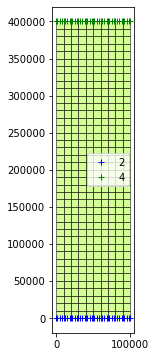

In [5]:
plotMesh(elements, nodes, [2, 4])

In [6]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points
xi,w,dh = readGLL(N)
print(f"{xi=}")

xi=array([-1.        , -0.65465367,  0.        ,  0.65465367,  1.        ])


In [7]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

def computeJacobian(e):
        
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]
            
    return e
    
with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeJacobian, elements), total=len(elements)))

100%|██████████| 400/400 [00:01<00:00, 258.79it/s]


In [8]:
# paramètres mécaniques béton

E = 30e9        # module d'Young
ν = 0.25        # coefficient de Poisson

# paramètres de Lamé
λ = (E*ν) / ((1+ν)*(1-2*ν))
μ = E / (2*(1+ν))

# masse volumique
ρ = 2500.0

# vitesses d'ondes
vp = np.sqrt((λ+2*μ)/ρ)
vs =np.sqrt(μ/ρ)

print(f"Vitesse des ondes P : {vp/1000:.3f}km/s")
print(f"Vitesse des ondes S : {vs/1000:.3f}km/s")


Vitesse des ondes P : 3.795km/s
Vitesse des ondes S : 2.191km/s


In [9]:
# calcul des matrices élémentaires

δ = np.eye(N+1)

def computeStiffnes(e):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros((2*(N+1)**2,2*(N+1)**2))
    
    Kdxdx = np.zeros((N+1,N+1,N+1,N+1))
    Kdydy = np.zeros((N+1,N+1,N+1,N+1))
    Kdxdy = np.zeros((N+1,N+1,N+1,N+1))
    Kdydx = np.zeros((N+1,N+1,N+1,N+1))
    
    for a in range(N+1):
        for b in range(N+1):
            for c in range(N+1):
                for d in range(N+1):
                       
                        for p in range(N+1):
                            for q in range(N+1):
                                
                                Kdxdx[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe11[p,q]*dh[c,p]*δ[d,q] + e.iJe12[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydy[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdxdy[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydx[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                
    for i in range(2*(N+1)**2):
        for j in range(2*(N+1)**2):
            
            a,b = i//2//(N+1), i//2%(N+1)
            c,d = j//2//(N+1), j//2%(N+1)
            
            if i%2 == 0 and j%2 == 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdxdx[a,b,c,d] + μ*Kdydy[a,b,c,d]             
                
            if i%2 == 0 and j%2 != 0:
                
                e.Ke[i,j] = λ*Kdxdy[a,b,c,d] + μ*Kdydx[a,b,c,d]      
            
            if i%2 != 0 and j%2 == 0:
                
                e.Ke[i,j] = λ*Kdydx[a,b,c,d] + μ*Kdxdy[a,b,c,d]             
                
            if i%2 != 0 and j%2 != 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdydy[a,b,c,d] + μ*Kdxdx[a,b,c,d] 
                                
    return e

# elements = list(tqdm(map(computeStiffnes, elements), total=len(elements)))

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeStiffnes, elements), total=len(elements)))

100%|██████████| 400/400 [00:12<00:00, 32.22it/s]


In [10]:
# calcul des matrices élémentaires de masse

for e in tqdm(elements):
    
    e.Me = np.zeros(2*(N+1)**2) # diagonal
    
    for i in range(2*(N+1)**2):
        e.Me[i] = ρ * w[i//2//(N+1)]*w[i//2%(N+1)]*e.detJ[i//2//(N+1),i//2%(N+1)]


100%|██████████| 400/400 [00:00<00:00, 9424.45it/s]


In [11]:
# assemblage

K = np.zeros((2*dof,2*dof))
M = np.zeros(2*dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        M[2*n1.id] += e.Me[2*i]
        M[2*n1.id+1] += e.Me[2*i+1]
        for (j,n2) in enumerate(e.nodes):
            K[2*n1.id,2*n2.id] += e.Ke[2*i,2*j]
            K[2*n1.id+1,2*n2.id] += e.Ke[2*i+1,2*j]
            K[2*n1.id,2*n2.id+1] += e.Ke[2*i,2*j+1]
            K[2*n1.id+1,2*n2.id+1] += e.Ke[2*i+1,2*j+1]

100%|██████████| 400/400 [00:01<00:00, 314.44it/s]


In [31]:
# définition source : sinus en cisaillement au niveau du sol

f0 = vs/(20*Δx)     # tuning
nodesBot1 = []
nodesBot2 = []
for n in nodes:
    if n.region == 2:
        nodesBot1.append(2*n.id)
        nodesBot2.append(2*n.id+1)
nodesBot1 = np.array(nodesBot1)
nodesBot2 = np.array(nodesBot2)

F = np.zeros(2*dof)

for n in nodesBot1:
    K[n,:] = 0
    K[n,n] = 1
for n in nodesBot2:
    K[n,:] = 0
    K[n,n] = 1
    

In [32]:
# inverting mass matrix

iM = 1/M

In [33]:
# résolution temporelle

Nit = 3000
cfl = 0.25
Δt = Δx/vp* cfl
T = Δt*Nit 

time = np.linspace(0,T,Nit)

U = np.zeros((Nit, 2*dof))
dU = np.zeros((Nit, 2*dof))
ddU = np.zeros((Nit, 2*dof))

In [34]:
# tests sur valeurs paramètres
print(f"CFL = {Δt/Δx*vp}")
print(f"Δx = {Δx}m while λmin ~ {vs/(4*f0)}")

CFL = 0.25000000000000006
Δx = 2000.0m while λmin ~ 10000.0


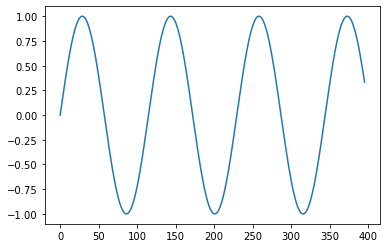

In [36]:
%matplotlib inline
plt.plot(time, np.sin(f0*time))

In [37]:
# FD
for i in tqdm(range(2,Nit)):
    F[nodesBot2] = np.sin(f0*i*Δt)
    U[i,:] = 2*U[i-1,:] - U[i-2,:] + Δt**2*np.multiply(iM , F - K@U[i-1,:])

100%|██████████| 2998/2998 [01:23<00:00, 35.93it/s]


In [38]:
%matplotlib tk
plt.plot(time, U[:,200])
# plt.plot(time, f(time))

In [39]:
import matplotlib.animation as animation

# %matplotlib widget
%matplotlib tk

In [42]:
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

it = 1000

plotDeformedMesh(elements, U[it,:], ax, 1e5)

In [39]:
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

# plotMeshLimits(elements, ax)

dtot = np.sqrt(U[:,::2]**2 + U[:,1::2]**2)

dmin = min(dtot.min(), -dtot.max())/3

dots = ax.scatter([n.x for n in nodes], [n.y for n in nodes], c=dtot[0,:], zorder=4, cmap="seismic", vmin=dmin, vmax=-dmin)

cbar = plt.colorbar(dots)
ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)

dit = 10

def animate(i):
    dots.set_array(dtot[dit*i,:])
    cbar.update_normal(dots)
    ttl.set_text(f"it = {dit*i}")
    return dots,ttl,

ani = animation.FuncAnimation(fig, animate, interval=300, blit=True, frames = int(Nit/dit))

ani.event_source.start()

plt.show()

In [16]:
# plot interpolation bourrin : interpolation régulière sur l'élément de référence pour chaque élément puis interpolation "nearest" sur le nuage de point créé

def interpPlot(U, elements = elements, onlyZ = True):
    
    phi = shapeFunctions["P1"]["phi"]
    hij = lagrangian2D(N)
    
    npts = 10
        
    u = np.linspace(-1, 1, npts)
    uu, vv = np.meshgrid(u,u)
    vmin, vmax = U.min(), U.max()

    if not(onlyZ): X,Y = np.zeros(len(elements)*npts**2),np.zeros(len(elements)*npts**2)
    
    Z = np.zeros(len(elements)*npts**2)
    
    for i,e in enumerate(elements):
        
        coords = e.getCoords()
        
        zitp = interp(hij, [U[n.id] for n in e.nodes])
        Z[i*npts**2:(i+1)*npts**2] = zitp(uu, vv).reshape(npts**2)

        if not(onlyZ):
            xitp = interp(phi, coords[:,0])
            yitp = interp(phi, coords[:,1])
            X[i*npts**2:(i+1)*npts**2] = xitp(uu, vv).reshape(npts**2)
            Y[i*npts**2:(i+1)*npts**2] = yitp(uu, vv).reshape(npts**2)
            
    if onlyZ: return Z
    return X,Y,Z 

In [17]:
X,Y,Uitp0 = interpPlot(U[0,:],elements,False)

dit_interp = 5
U_list = [U[i,:] for i in range(1,Nit,dit_interp)]

with Pool(nprocesses) as p:
    Uitp = [Uitp0] + list(tqdm(p.imap(interpPlot, U_list), total=len(U_list)))

100%|██████████| 400/400 [01:12<00:00,  5.53it/s]


In [20]:
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

# plotMeshLimits(elements, ax)

umin = min(U.min(), -U.max())/3

dots = ax.scatter(X, Y, c=Uitp[0], zorder=4, cmap="seismic", vmin=umin, vmax=-umin, marker=",")

cbar = plt.colorbar(dots)

ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)

dit = 2

def animate(i):
    dots.set_array(Uitp[dit*i])
    cbar.update_normal(dots)
    ttl.set_text(f"it = {dit_interp*dit*i}")
    return dots,ttl,

ani = animation.FuncAnimation(fig, animate, interval=100, blit=True, frames = len(Uitp))

ani.event_source.start()

plt.show()